# NASA POWER API - Solar Irradiance Data

This notebook retrieves yearly average solar power irradiance data from NASA's POWER API.

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

In [2]:
year = 2023
num_years = 10

start_date = year - num_years + 1
end_date = year

In [3]:
# Define the parameter(s) you want (here global horizontal irradiance)
parameters = "ALLSKY_SFC_SW_DWN"

test_latitude = 40.0
test_longitude = -90.0

# Construct the API URL
test_url = (
    f"https://power.larc.nasa.gov/api/temporal/monthly/point?"
    f"parameters={parameters}&"
    f"community=RE&"
    f"longitude={test_longitude}&"
    f"latitude={test_latitude}&"
    f"start={start_date}&"
    f"end={end_date}&"
    f"format=JSON"
)

# Make the API call
response = requests.get(test_url)

# Check if the call was successful
if response.status_code == 200:
    data = response.json()
    # Print the result in a formatted way
    print(json.dumps(data, indent=2))
    
else:
    print("Error:", response.status_code, response.text)

{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [
      -90.0,
      40.0,
      172.74
    ]
  },
  "properties": {
    "parameter": {
      "ALLSKY_SFC_SW_DWN": {
        "201401": 1.9,
        "201402": 2.6,
        "201403": 3.85,
        "201404": 4.81,
        "201405": 5.77,
        "201406": 6.06,
        "201407": 6.53,
        "201408": 4.73,
        "201409": 4.7,
        "201410": 2.82,
        "201411": 1.95,
        "201412": 1.34,
        "201413": 3.92,
        "201501": 1.82,
        "201502": 3.17,
        "201503": 4.32,
        "201504": 5.21,
        "201505": 5.6,
        "201506": 5.59,
        "201507": 5.78,
        "201508": 5.8,
        "201509": 4.67,
        "201510": 3.41,
        "201511": 2.25,
        "201512": 1.39,
        "201513": 4.08,
        "201601": 2.0,
        "201602": 2.89,
        "201603": 3.59,
        "201604": 4.74,
        "201605": 5.82,
        "201606": 7.37,
        "201607": 6.09,
        "201608": 

## Set up API parameters

The ALLSKY_SFC_SW_DWN parameter represents the all-sky surface downward shortwave irradiance (W/m²).

In [4]:
# Define location (Brazil)
test_latitude = -10.7833
test_longitude = -53.08334

# NASA POWER API parameters
base_url = "https://power.larc.nasa.gov/api/temporal/monthly/point?"
parameters = "ALLSKY_SFC_SW_DWN"  # Solar irradiance at surface level (W/m²)

# Build the full API request URL
params = {
    "parameters": parameters,
    "community": "RE",  # Renewable Energy community
    "longitude": test_longitude,
    "latitude": test_latitude,
    "start": start_date,
    "end": end_date,
    "format": "JSON"
}

print(f"Retrieving solar irradiance data for coordinates ({test_latitude}, {test_longitude}) for year {year-1}")

Retrieving solar irradiance data for coordinates (-10.7833, -53.08334) for year 2022


## Make API request and process the data

In [5]:
# Make the API request
response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()
    
    # Extract the solar irradiance data
    irradiance_data = data['properties']['parameter']['ALLSKY_SFC_SW_DWN']
    
    # Convert to DataFrame for easier processing
    df = pd.DataFrame(list(irradiance_data.items()), columns=['Date', 'Irradiance'])
    
    # Calculate yearly average
    yearly_avg = df['Irradiance'].mean()
    
    print(f"\nYearly average solar irradiance: {yearly_avg:.2f} W/m²")
    
    # Display first few rows of data
    print("\nSample of daily irradiance data:")
    print(df.head())
    
else:
    print(f"Error fetching data: {response.status_code}")
    print(response.text)


Yearly average solar irradiance: 5.49 W/m²

Sample of daily irradiance data:
     Date  Irradiance
0  201401        5.51
1  201402        4.77
2  201403        4.84
3  201404        5.22
4  201405        5.23


## Visualize monthly averages

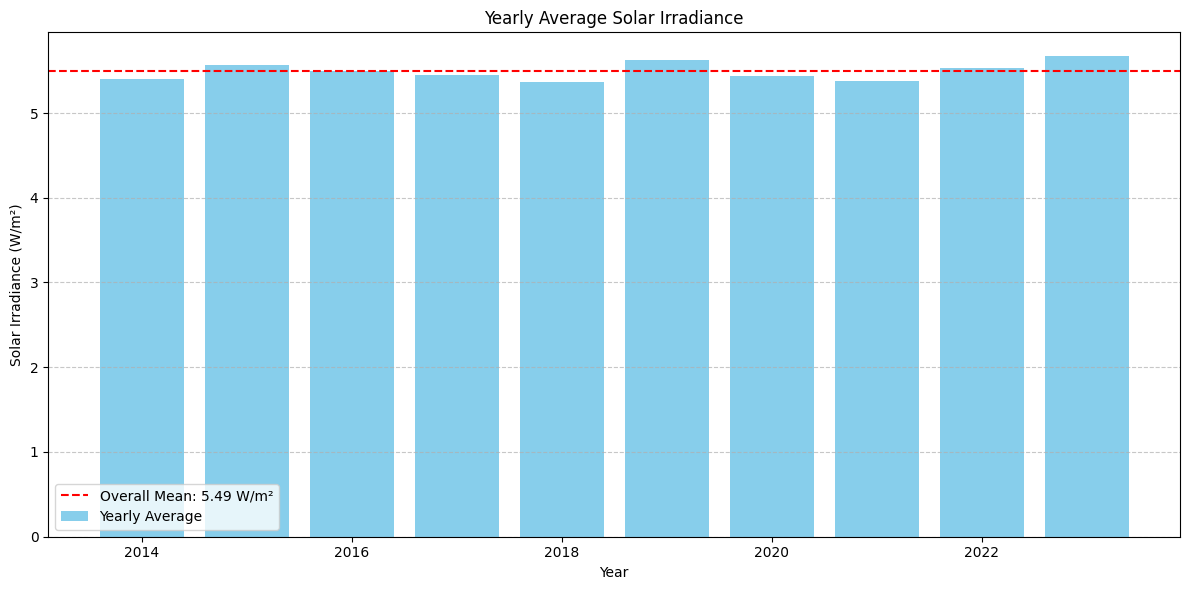

In [6]:
# Data processing and visualization
if response.status_code == 200:
    # Add year column by extracting year from Date
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%M')
    df['Year'] = df['Date'].dt.year
    
    # Extract month for plotting
    df['Month'] = df['Date'].dt.month
    
    # Calculate yearly averages for each year in the dataset
    yearly_avgs = df.groupby('Year')['Irradiance'].mean().reset_index()
    
    # Calculate overall mean across all years
    overall_mean = yearly_avgs['Irradiance'].mean()
    
    # Plot yearly averages
    plt.figure(figsize=(12, 6))
    plt.bar(yearly_avgs['Year'], yearly_avgs['Irradiance'], color='skyblue', label='Yearly Average')
    
    # Add a horizontal line for the mean
    plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f} W/m²')
        
    plt.title(f'Yearly Average Solar Irradiance')
    plt.xlabel('Year')
    plt.ylabel('Solar Irradiance (W/m²)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Geographic Visualization of Solar Irradiance

This section fetches solar irradiance data for a grid of locations and visualizes it on a map.

In [7]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import time

In [8]:
# Resolution of the grid (lower = more resolution but more API calls)
resolution = 4.0 # degrees

In [9]:
# Creating a grid of coordinates
min_lat, max_lat = -60, 20
min_lon, max_lon = -90, -30

# Generate grid coordinates
lats = np.arange(min_lat, max_lat + resolution, resolution)
lons = np.arange(min_lon, max_lon + resolution, resolution)

print(f"Grid size: {len(lats)}x{len(lons)} = {len(lats)*len(lons)} points")

# Create list of coordinate pairs
coordinates = [(lat, lon) for lat in lats for lon in lons]

# Show sample of coordinates that will be queried
print(f"Sample coordinates: {coordinates[:5]}")

Grid size: 21x16 = 336 points
Sample coordinates: [(np.float64(-60.0), np.float64(-90.0)), (np.float64(-60.0), np.float64(-86.0)), (np.float64(-60.0), np.float64(-82.0)), (np.float64(-60.0), np.float64(-78.0)), (np.float64(-60.0), np.float64(-74.0))]


In [10]:
def fetch_yearly_avg_irradiance(lat, long):
    params = {
        "parameters": parameters,
        "community": "RE",  # Renewable Energy community
        "latitude": lat,
        "longitude": long,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }
    
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
        
        irradiance_data = data['properties']['parameter']['ALLSKY_SFC_SW_DWN']
        
        df = pd.DataFrame(list(irradiance_data.items()), columns=['Date', 'Irradiance'])
        
        yearly_avg = df['Irradiance'].mean()
        return lat, long, yearly_avg
    
    else:
        print(f"Error fetching data: {response.status_code}")
        print(response.text)
        print(f"Calling the funtion again...")
        time.sleep(1000)
        fetch_yearly_avg_irradiance(lat, long)

In [11]:
def fetch_irradiance_grid(min_lat, max_lat, min_lon, max_lon, resolution):
    """
    Fetch solar irradiance data from NASA POWER API for a geographical grid.
    
    Parameters:
    -----------
    min_lat : float
        Minimum latitude of the area
    max_lat : float
        Maximum latitude of the area
    min_lon : float
        Minimum longitude of the area
    max_lon : float
        Maximum longitude of the area
    resolution : float
        Spacing between coordinates in degrees
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing latitude, longitude, and irradiance values
    """
    # Generate latitude and longitude arrays
    lats = np.arange(min_lat, max_lat + resolution, resolution)
    lons = np.arange(min_lon, max_lon + resolution, resolution)
    
    # Create all coordinate combinations
    coordinates = [(lat, lon) for lat in lats for lon in lons]
    
    # Limit the number of points to fetch (to avoid API rate limits)
    max_points = len(lats) * len(lons)
    
    print(f"Fetching data for {len(coordinates)} locations...")

    # Fetch data using multithreading to speed up the process
    results = []
    with ThreadPoolExecutor(max_workers=None) as executor:
        futures = [executor.submit(fetch_yearly_avg_irradiance, lat, lon) 
                  for lat, lon in coordinates]
        
        for future in tqdm(futures):
            results.append(future.result())

    # Filter out any failed requests
    valid_results = [(lat, lon, avg) for lat, lon, avg in results if avg is not None]

    print(f"Successfully retrieved data for {len(valid_results)} out of {len(coordinates)} locations")

    # Extract data for visualization
    map_data = [(lat, lon, avg) for lat, lon, avg in valid_results]

    # Create DataFrame from results
    irradiance_df = pd.DataFrame(map_data, columns=['latitude', 'longitude', 'irradiance'])
    
    # Save to CSV
    csv_filename = f"irradiance_data_res{resolution}.csv"
    irradiance_df.to_csv(csv_filename, index=False)
    print(f"Data saved to {csv_filename}")
    
    return irradiance_df

In [12]:
import time
import pandas as pd

def fetch_irradiance_grid_in_quadrants(min_lat, max_lat, min_lon, max_lon, resolution=2., sleep_seconds=60):
    """
    Fetch solar irradiance data by dividing the area into 4 quadrants with sleep time between calls.
    
    Parameters:
    -----------
    min_lat, max_lat, min_lon, max_lon : float
        Boundaries of the target area
    resolution : float
        Spacing between coordinates in degrees
    sleep_seconds : int, optional
        Sleep time between API calls in seconds (default: 60)
        
    Returns:
    --------
    pd.DataFrame
        Combined DataFrame with all irradiance data
    """
    # Calculate the midpoints to split the area into 4 quadrants
    mid_lat = (min_lat + max_lat) / 2
    mid_lon = (min_lon + max_lon) / 2
    
    # Define the 4 quadrants
    quadrants = [
        {"name": "Southwest", "min_lat": min_lat, "max_lat": mid_lat, "min_lon": min_lon, "max_lon": mid_lon},
        {"name": "Southeast", "min_lat": min_lat, "max_lat": mid_lat, "min_lon": mid_lon, "max_lon": max_lon},
        {"name": "Northeast", "min_lat": mid_lat, "max_lat": max_lat, "min_lon": mid_lon, "max_lon": max_lon},
        {"name": "Northwest", "min_lat": mid_lat, "max_lat": max_lat, "min_lon": min_lon, "max_lon": mid_lon}
    ]
    
    # List to collect dataframes from each quadrant
    quadrant_dfs = []
    
    # Fetch each quadrant with sleep time between calls
    for i, q in enumerate(quadrants):
        print(f"\n=== Fetching {q['name']} quadrant ({i+1}/4) ===")
        print(f"Coordinates: Lat [{q['min_lat']:.4f} to {q['max_lat']:.4f}], Lon [{q['min_lon']:.4f} to {q['max_lon']:.4f}]")
        
        df = fetch_irradiance_grid(
            min_lat=q['min_lat'],
            max_lat=q['max_lat'],
            min_lon=q['min_lon'],
            max_lon=q['max_lon'],
            resolution=resolution
        )
        
        quadrant_dfs.append(df)
        
        # Sleep before the next quadrant (except after the last one)
        if i < 3:
            print(f"Sleeping for {sleep_seconds} seconds before next quadrant...")
            time.sleep(sleep_seconds)
    
    # Merge all dataframes
    print("\n=== Merging all quadrant data ===")
    combined_df = pd.concat(quadrant_dfs, ignore_index=True)
    
    # Remove any duplicates that might occur at the boundaries
    combined_df = combined_df.drop_duplicates(subset=['latitude', 'longitude'])
    
    # Save the combined dataset
    combined_filename = f"irradiance_data_full_res{resolution}.csv"
    combined_df.to_csv(combined_filename, index=False)
    print(f"Combined dataset with {len(combined_df)} points saved to {combined_filename}")
    
    return combined_df

In [13]:
# Example usage
irradiance_df = fetch_irradiance_grid_in_quadrants(
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
    resolution=2,
    sleep_seconds=200  # 2 minutes between API calls
)


=== Fetching Southwest quadrant (1/4) ===
Coordinates: Lat [-60.0000 to -20.0000], Lon [-90.0000 to -60.0000]
Fetching data for 336 locations...


  0%|          | 0/336 [00:00<?, ?it/s]

Successfully retrieved data for 336 out of 336 locations
Data saved to irradiance_data_res2.csv
Sleeping for 200 seconds before next quadrant...

=== Fetching Southeast quadrant (2/4) ===
Coordinates: Lat [-60.0000 to -20.0000], Lon [-60.0000 to -30.0000]
Fetching data for 336 locations...


  0%|          | 0/336 [00:00<?, ?it/s]

Successfully retrieved data for 336 out of 336 locations
Data saved to irradiance_data_res2.csv
Sleeping for 200 seconds before next quadrant...

=== Fetching Northeast quadrant (3/4) ===
Coordinates: Lat [-20.0000 to 20.0000], Lon [-60.0000 to -30.0000]
Fetching data for 336 locations...


  0%|          | 0/336 [00:00<?, ?it/s]

Successfully retrieved data for 336 out of 336 locations
Data saved to irradiance_data_res2.csv
Sleeping for 200 seconds before next quadrant...

=== Fetching Northwest quadrant (4/4) ===
Coordinates: Lat [-20.0000 to 20.0000], Lon [-90.0000 to -60.0000]
Fetching data for 336 locations...


  0%|          | 0/336 [00:00<?, ?it/s]

Successfully retrieved data for 336 out of 336 locations
Data saved to irradiance_data_res2.csv

=== Merging all quadrant data ===
Combined dataset with 1271 points saved to irradiance_data_full_res2.csv


In [14]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"irradiance_data_full_res{resolution}.csv"
irradiance_df.to_csv(csv_filename, index=False)
print(f"Data saved to {csv_filename}")

Data saved to irradiance_data_full_res4.0.csv


In [15]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from scipy.interpolate import griddata

In [53]:
irradiance_df = pd.read_csv('irradiance_data_full_res2.csv')

In [54]:
unique_lats = irradiance_df['latitude'].nunique()
unique_lons = irradiance_df['longitude'].nunique()

print(unique_lats, unique_lons)

41 31


In [55]:
# Create a finer grid for interpolation
grid_lat = np.linspace(min_lat, max_lat, 401)
grid_lon = np.linspace(min_lon, max_lon, 301)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

# Interpolate data - Important: Note the order of coordinates for proper interpolation
points = irradiance_df[['longitude', 'latitude']].values
values = irradiance_df['irradiance'].values
# Use the same coordinate order for sample points and grid points
grid_irr = griddata(points, values, (grid_lon, grid_lat), method='cubic')

In [56]:
interpolated_df = pd.DataFrame({
    'latitude': grid_lat.flatten(),
    'longitude': grid_lon.flatten(),
    'interpolated_irradiance': grid_irr.flatten()
})

interpolated_df = interpolated_df.dropna()

interp_csv_filename = f"interpolated_irradiance_{year}_res{resolution}.csv"
interpolated_df.to_csv(interp_csv_filename, index=False)
print(f"Interpolated data saved to {interp_csv_filename}")

Interpolated data saved to interpolated_irradiance_2023_res4.0.csv


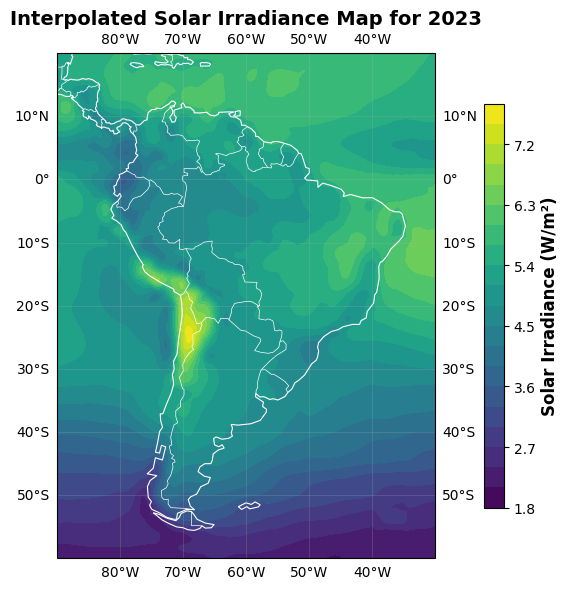

In [57]:
# Create a new figure with proper cartopy projection
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the contour on the cartopy axes with proper projection
contour = ax.contourf(grid_lon, grid_lat, grid_irr, cmap='viridis', 
                      levels=20, transform=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.8)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.5)

# Add a color bar with clear labeling - increased pad value to move it right
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, shrink=0.8)
cbar.set_label('Solar Irradiance (W/m²)', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3)

# Set extent based on our data bounds
ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())

plt.title(f'Interpolated Solar Irradiance Map for {year}', fontsize=14, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(alpha=0.3)
plt.tight_layout()  # Added tight_layout for better spacing
plt.show()